In [1]:
import sys, os
import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
# from umap import UMAP
from sklearn.decomposition import PCA

In [67]:
class cfrmModel(Module):
    def __init__(self, dir, N=3, batch_size=100, lr=1e-3, dropout=0.1):
        super().__init__()
        self.batch_size = batch_size
        self.alpha = torch.FloatTensor([1, 1, 1, 1, 10])
        self.dropout = dropout
        # data
        counts_rna = np.loadtxt(os.path.join(dir, 'GxC1.txt')).T
        counts_atac = np.loadtxt(os.path.join(dir, 'RxC2.txt')).T
        
        counts_rna = preprocess(counts = counts_rna, mode = "quantile", modality = "RNA")
        counts_atac = preprocess(counts = counts_atac, mode = "quantile", modality= "ATAC")

        self.G = torch.FloatTensor(counts_rna)
        self.R = torch.FloatTensor(counts_atac)
        self.A = torch.FloatTensor(np.loadtxt(os.path.join(dir, 'RxG.txt')))
        assert self.A.shape[0] == self.R.shape[1]
        assert self.A.shape[1] == self.G.shape[1]
        self.label_g = torch.LongTensor(np.loadtxt(os.path.join(dir, 'gene_label.txt')))
        self.label_c1 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C1.txt'), skiprows=1, usecols=[1]))
        self.label_c2 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C2.txt'), skiprows=1, usecols=[1]))

        # learnable parameters
        self.D_gr = Parameter(torch.ones(N, 1))
        u_g, s_g, v_g = torch.svd(self.G)
        self.C_1 = Parameter(u_g[:, :N])
        self.C_g = Parameter(v_g[:, :N])
#         with torch.no_grad():
#             self.C_1 += torch.randn(self.C_1.shape)
#             self.C_g += torch.randn(self.C_g.shape)
        self.A_1g = self.C_1.t() @ self.G @ self.C_g
        u_r, s_r, v_r = torch.svd(self.R)
        self.C_2 = Parameter(u_r[:, :N])
        self.C_r = Parameter(v_r[:, :N])
#         with torch.no_grad():
#             self.C_2 += torch.randn(self.C_2.shape)
#             self.C_r += torch.randn(self.C_r.shape)
        self.A_2r = self.C_2.t() @ self.R @ self.C_r
#         self.D_12 = torch.diag((self.A_1g * self.A_2r).sum(dim=1) / self.A_2r.pow(2).sum(dim=1)).detach()
        self.D_12 = torch.eye(N)
        loss = self.batch_loss('valid')
        for l in loss:
            print(l.item())
        # optimizer
        self.optimizer = opt.Adam(self.parameters(), lr=lr)

    @staticmethod
    def orthogonal_loss(A):
        return (A.t() @ A - torch.eye(A.shape[1])).pow(2).sum()

    def batch_loss(self, mode='C_c'):
        if mode == 'C_c':
            loss1 = (self.G - self.C_1 @ self.A_1g.detach() @ self.C_g.detach().t()).pow(2).mean()
            loss2 = (self.R - self.C_2 @ self.A_2r.detach() @ self.C_r.detach().t()).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2]))
            loss3, loss4 = 0, 0
        elif mode == 'C_r':
            loss2 = (self.R - self.C_2.detach() @ self.A_2r.detach() @ self.C_r.t()).pow(2).mean()
            loss3 = (self.A - self.C_r @ (self.D_gr.detach() * self.C_g.detach().t())).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_r]))
            loss1, loss4 = 0, 0
        elif mode == 'C_g':
            loss1 = (self.G - self.C_1.detach() @ self.A_1g.detach() @ self.C_g.t()).pow(2).mean()
            loss3 = (self.A - self.C_r.detach() @ (self.D_gr.detach() * self.C_g.t())).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_g]))
            loss2, loss4 = 0, 0
        elif mode == 'valid':
            with torch.no_grad():
                loss1 = (self.G - self.C_1 @ self.A_1g @ self.C_g.t()).pow(2).mean()
                loss2 = (self.R - self.C_2 @ self.A_2r @ self.C_r.t()).pow(2).mean()
                loss3 = (self.A - self.C_r @ (self.D_gr * self.C_g.t())).pow(2).mean()
                loss4 = (self.A_1g - self.D_12 * self.A_2r).pow(2).mean()
                loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2, self.C_g, self.C_r]))
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3 + self.alpha[3] * loss4 + \
               self.alpha[4] * loss5
        # loss1 = (self.G - self.C_1 @ self.A_1g @ self.C_g.t()).pow(2).sum()
        # loss2 = (self.R - self.C_2 @ self.A_2r @ self.C_r.t()).pow(2).sum()
        # loss3 = (self.A - self.C_r @ (self.D_gr * self.C_g.t())).pow(2).sum()
        # loss4 = (self.A_1g - self.D_12 * self.A_2r).pow(2).mean()
        # loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2, self.C_g, self.C_r]))
        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3, self.alpha[3] * loss4, \
               self.alpha[4] * loss5

    def train_func(self, T):
        best_loss = 1e12
        count = 0
        for t in range(T):
            self.optimizer.zero_grad()
            for mode in ['C_c']:
            # for mode in ['C_c', 'C_r', 'C_g']:
                loss, loss1, loss2, loss3, loss4, loss5 = self.batch_loss(mode)
                loss.backward()
                self.optimizer.step()
            self.A_1g = self.C_1.t() @ self.G @ self.C_g
            self.A_2r = self.C_2.t() @ self.R @ self.C_r
            self.D_12 = torch.diag((self.A_1g * self.A_2r).sum(dim=1) / self.A_2r.pow(2).sum(dim=1)).detach()
            
            loss, loss1, loss2, loss3, loss4, loss5 = self.batch_loss('valid')
            print('Epoch {}, Training Loss: {:.4f}'.format(t+1, loss.item()))
            info = [
                'loss RNA: {:.5f}'.format(loss1.item()),
                'loss ATAC: {:.5f}'.format(loss2.item()),
                'loss gene act: {:.5f}'.format(loss3.item()),
                'loss merge: {:.5f}'.format(loss4.item()),
                'loss ortho: {:.5f}'.format(loss5.item()),
            ]
            for i in info:
                print("\t", i)
            if loss.item() < best_loss:
                best_loss = loss.item()
                count = 0
            else:
                count += 1
                if count % 20 == 0:
                    self.optimizer.param_groups[0]['lr'] *= 0.5
                    print('Epoch: {}, shrink lr to {:.4f}'.format(t+1, self.optimizer.param_groups[0]['lr']))
                    if self.optimizer.param_groups[0]['lr'] < 1e-4:
                        break
                    else:
                        count = 0
                    


In [68]:
model = cfrmModel(dir = '../data/simulated/2batches_3clusts', N=3, dropout=0)
model.train_func(T=100000)

157575.6875
0.2241944968700409
0.04583536460995674
0.00041880420758388937
157575.421875
1.3905042395290224e-10
Epoch 1, Training Loss: 28.3084
	 loss RNA: 0.22507
	 loss ATAC: 0.04621
	 loss gene act: 0.00042
	 loss merge: 27.78328
	 loss ortho: 0.25338
Epoch 2, Training Loss: 11.3868
	 loss RNA: 0.22550
	 loss ATAC: 0.04587
	 loss gene act: 0.00042
	 loss merge: 11.08179
	 loss ortho: 0.03327
Epoch 3, Training Loss: 10.6630
	 loss RNA: 0.22464
	 loss ATAC: 0.04593
	 loss gene act: 0.00042
	 loss merge: 10.33304
	 loss ortho: 0.05895
Epoch 4, Training Loss: 47.3148
	 loss RNA: 0.22496
	 loss ATAC: 0.04606
	 loss gene act: 0.00042
	 loss merge: 46.89683
	 loss ortho: 0.14651
Epoch 5, Training Loss: 70.0962
	 loss RNA: 0.22533
	 loss ATAC: 0.04599
	 loss gene act: 0.00042
	 loss merge: 69.71448
	 loss ortho: 0.10995
Epoch 6, Training Loss: 62.0362
	 loss RNA: 0.22476
	 loss ATAC: 0.04587
	 loss gene act: 0.00042
	 loss merge: 61.73600
	 loss ortho: 0.02915
Epoch 7, Training Loss: 39.4772

Epoch 57, Training Loss: 34.7854
	 loss RNA: 0.22421
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 34.51472
	 loss ortho: 0.00022
Epoch 58, Training Loss: 34.6591
	 loss RNA: 0.22421
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 34.38846
	 loss ortho: 0.00012
Epoch 59, Training Loss: 34.3936
	 loss RNA: 0.22421
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 34.12307
	 loss ortho: 0.00004
Epoch 60, Training Loss: 34.0341
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.76365
	 loss ortho: 0.00001
Epoch 61, Training Loss: 33.6383
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.36784
	 loss ortho: 0.00002
Epoch 62, Training Loss: 33.2702
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 32.99967
	 loss ortho: 0.00006
Epoch 63, Training Loss: 32.9919
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 32.72128
	 loss ortho: 

Epoch 114, Training Loss: 33.5979
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.32747
	 loss ortho: 0.00000
Epoch 115, Training Loss: 33.6075
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.33705
	 loss ortho: 0.00000
Epoch 116, Training Loss: 33.6170
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.34649
	 loss ortho: 0.00000
Epoch 117, Training Loss: 33.6258
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.35533
	 loss ortho: 0.00000
Epoch 118, Training Loss: 33.6337
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.36327
	 loss ortho: 0.00000
Epoch 119, Training Loss: 33.6406
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.37009
	 loss ortho: 0.00000
Epoch 120, Training Loss: 33.6460
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.37553
	 loss 

Epoch 170, Training Loss: 33.5984
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.32792
	 loss ortho: 0.00000
Epoch 171, Training Loss: 33.5984
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.32793
	 loss ortho: 0.00000
Epoch 172, Training Loss: 33.5984
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.32797
	 loss ortho: 0.00000
Epoch 173, Training Loss: 33.5984
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.32797
	 loss ortho: 0.00000
Epoch 174, Training Loss: 33.5984
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.32794
	 loss ortho: 0.00000
Epoch 175, Training Loss: 33.5984
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.32791
	 loss ortho: 0.00000
Epoch 176, Training Loss: 33.5984
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.32790
	 loss 

In [69]:
print(model.A_1g)
print(model.A_2r)
print(model.D_12)
(model.A_1g - model.D_12 * model.A_2r).pow(2).mean()

tensor([[ 1.6974e+03,  3.3693e+00,  9.1338e-01],
        [-1.5268e+01,  3.7449e+02, -1.5351e-01],
        [-7.3750e+00,  2.3366e-01,  2.1067e+02]], grad_fn=<MmBackward>)
tensor([[ 5.2017e+02, -1.7201e+00, -3.9657e-01],
        [ 3.9921e+00,  2.2510e+02,  3.3149e-01],
        [ 1.8669e+00, -6.4144e-01,  1.1111e+02]], grad_fn=<MmBackward>)
tensor([[3.2631, 0.0000, 0.0000],
        [0.0000, 1.6619, 0.0000],
        [0.0000, 0.0000, 1.8944]])


tensor(33.3270, grad_fn=<MeanBackward0>)

In [70]:
pca_op = PCA(n_components = 2)
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

In [71]:
label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

None


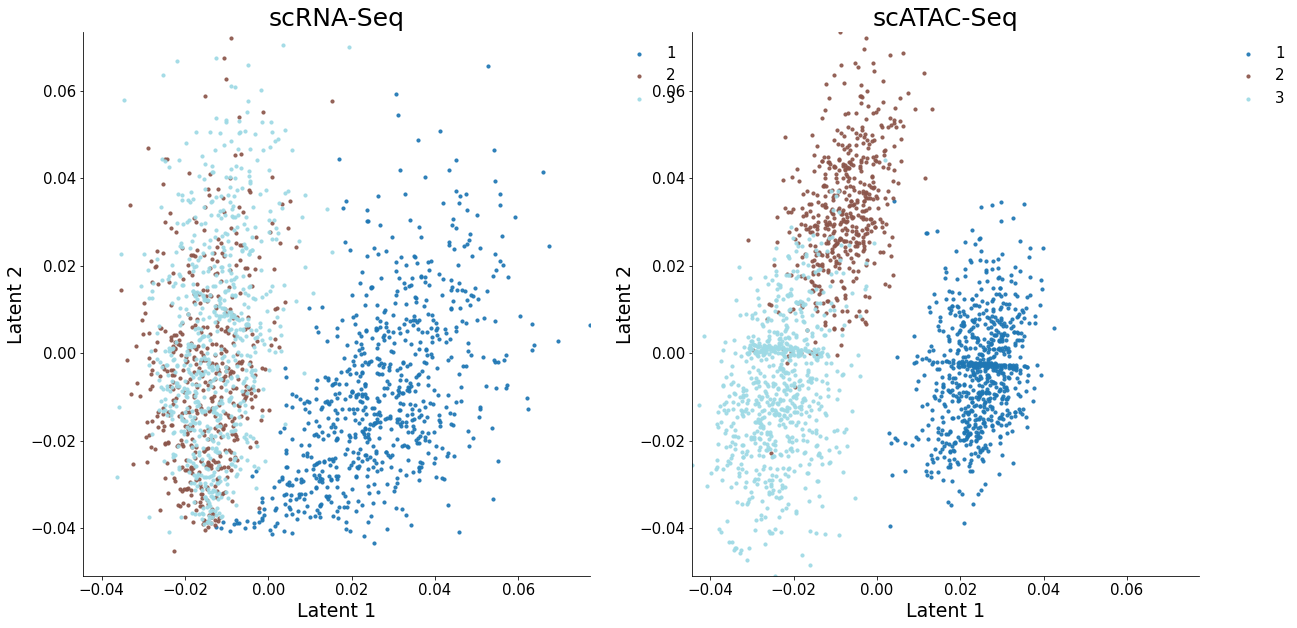

In [72]:
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

/Users/hanransun/PycharmProjects/CFRM/src
